In [245]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import collections
import matplotlib.pyplot as plt
import helper

In [246]:
def partial_shading(data):
    
    d_data = []
    
    num_partial_p = np.random.randint(2,6)

    percent = []
    for i in range(num_partial_p):
        if i % 2 == 0:
            level = np.random.uniform(0.1,0.5)
        else:
            level = 1
        percent.append(level)
        
    points = []
    for i in range(num_partial_p):
        points.append(np.random.randint(0,len(data)))
    points.sort()

    partial = {point:level for point, level in zip(points,percent)}
    
    d_data = []
    factor = []
    level = 1
        
    for j,j_data in enumerate(data):
        
        if j in partial:
            level = partial[j]            
        d_data.append(j_data*level*(1+np.random.normal(0,0.01)))  
        factor.append(level)
    
    return d_data,factor

def confusion_matrix_plot(cm,acc,save=False):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1) 
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True,fmt='g',annot_kws={"size": 25},cmap="Blues", square=True, cbar=False)
    
    title_name = 'Confusion Matrix - Accuracy ' + str(round(acc,2)) + "%"
    ax.set_title(title_name,fontsize=30)

    # labels, title and ticks
    ax.set_xlabel('Prediction',fontsize=25)
    ax.set_ylabel('Ground Truth',fontsize=25)
    ax.xaxis.set_ticklabels(['Normal', 'Open Circuit', 'Object Cover'],fontsize=20)
    ax.yaxis.set_ticklabels(['Normal', 'Open Circuit', 'Object Cover'],fontsize=20)

    plt.tight_layout()
    if save is True:
        plt.savefig('synthetic_experiment.jpg', format='jpg', dpi=1000)
    plt.show()

## Create Synthetic Data

In [247]:
class synthetic_data:
    def __init__(self,dataset):
        self.panel_record = {}
        self.defect_record = {}
        self.store_df = {}
        
        self.dataset = dataset
        self.solar_tk = dataset[['date','solar-tk']]
        self.snow = dataset[['date','snow_depth']]
        
#         self.dataset = self.dataset[self.dataset['label']=='normal']
        
        drop_col = [d_col for d_col in self.dataset.columns if d_col[:5] != 'panel' and d_col != 'date']
        self.dataset = self.dataset.drop(drop_col,axis=1)
        self.panels = [i for i in self.dataset.columns if i != 'date']
        
    def sample_index(self, data,origin_data):
        feature_index = []
        while len(feature_index) < len(origin_data):
            index = np.random.randint(0,len(data))
            if index not in feature_index:
                feature_index.append(index)
        feature_index.sort()
    
        return np.array(data)[feature_index]

    def leaf_feature(self, data):
        leaf_feature = pd.read_csv('leaf_cover.csv')
    
        one_leaf = leaf_feature[610:900]
        one_feature = one_leaf['power_1']/one_leaf['power_2'].values
        one_feature = self.sample_index(one_feature,data)

        two_leaf = leaf_feature[1570:1903]
        two_feature = two_leaf['power_1']/two_leaf['power_2'].values
        two_feature = self.sample_index(two_feature,data)

        three_leaf = leaf_feature[1964:2242]
        three_feature = three_leaf['power_1']/three_leaf['power_2'].values
        three_feature = self.sample_index(three_feature,data)

        four_leaf = leaf_feature[3006:3280]
        four_feature = four_leaf['power_1']/four_leaf['power_2'].values
        four_feature = self.sample_index(four_feature,data)

        five_leaf = leaf_feature[3344:3655]
        five_feature = five_leaf['power_1']/five_leaf['power_2'].values
        five_feature = self.sample_index(five_feature,data)
    
        return one_feature, two_feature, three_feature, four_feature, five_feature
        
    def dust_cover(self,data):
    
        d_data = []
        levels = []
    
        one_leaf, two_leaf, three_leaf, four_leaf, five_leaf = self.leaf_feature(data)
        level_feature = {1:one_leaf,2:two_leaf,3:three_leaf,4:four_leaf,5:five_leaf}
    
        leaf_num = np.random.randint(3,6)
        level = level_feature[leaf_num]
        
        data = np.array(data)*level
    
        return data

    def normal_noise_data(self, data):
    
        d_data = []
        for i in data:
            d_data.append(i*(1+np.random.normal(0,0.05)))
        return d_data

    def open_circuit(self, data):
    
        d_data = []
        break_p = np.random.randint(0,0.7*len(data))
    
        levels = []
    
        for i, i_data in enumerate(data):
            if i < break_p:
                levels.append(1)
                d_data.append(i_data*(1+np.random.normal(0,0.01)))
            else:
                d_data.append(1+np.random.normal(0,1))
                levels.append(1+np.random.normal(0,0.01))
            
        return d_data, levels
        
    def induce_defect(self, dataset, day, d_panel):
        # Extract the power output of the defect panel on given day 
        data = self.dataset[self.dataset['date']==day].drop(['date'],axis=1)[d_panel].values
        # Randomly define condition
        cond = random.choice(['open','cover','normal'])
        # Only use the high correlated and high power data to induce defect
        if len(data) < 50 or max(data) < 60:
            cond = 'normal'
    
        # Record the defect panel 
        if day not in self.panel_record:
            self.panel_record[day] = []
            
        if day not in self.defect_record:
            self.defect_record[day] = []
            
        # Record the panel that been induced by defect    
        self.panel_record[day].append(d_panel)
        cols = [i for i in dataset.columns if i[:5]=='panel']
    
        if cond == 'open':
            d_data,_ = self.open_circuit(data)
            # Record the type of defect 
            if d_panel not in self.defect_record[day]:
                self.defect_record[day] = {col:None for col in cols}
            self.defect_record[day][d_panel] = 'open'
            
        elif cond == 'normal':
            d_data = self.normal_noise_data(data)
            if d_panel not in self.defect_record[day]:
                self.defect_record[day] = {col:None for col in cols}
            self.defect_record[day][d_panel] = 'normal'
            
        else:
            d_data = self.dust_cover(data)
            if d_panel not in self.defect_record[day]:
                self.defect_record[day] = {col:None for col in cols}
            self.defect_record[day][d_panel] = 'cover'

            
        return d_data
            
    def generate_data(self):
        
        day_list = list(set(self.dataset['date']))
        
        while day_list:
    
            # Pop random day
            random.shuffle(day_list)
            day = day_list.pop()
            
            # Randomly induce multiple defects on panels
#             num_defect = np.random.randint(1,4)
            num_defect = 1
            d_panel_dict = {}
            
            for _ in range(num_defect):
    
                # Pop random panel
                random.shuffle(self.panels)
                d_panel = self.panels.pop()
            
                # Induce defect on panel
                d_data = self.induce_defect(self.dataset,day,d_panel)
            
                if d_data is not None:
                    d_panel_dict[d_panel] = d_data
                
            # Reassemble the normal panel and defect panel back to dataframe
            df = self.dataset[self.dataset['date']==day].drop(['date'],axis=1)
            for d_panel in d_panel_dict:
                df[d_panel] = d_panel_dict[d_panel]
            self.store_df[day] = df
            
            self.panels = [i for i in self.dataset.columns if i != 'date']
             
    def generate_feature(self):
        self.generate_data()
        
        day_list = [i for i in self.store_df]
        df_feature = pd.DataFrame()
        bad_day = []
        day_col = []
        max_power = []
        s_depth = []
        count = 0

        for day in day_list:
            # Extract daily data
            data = self.store_df[day]
            
            if len(data) < 50:
                continue
            
            panels = list(data.columns)
            
            # Generate 40 feature 
            feature_index = []
            while len(feature_index) < 40:
                index = np.random.randint(0,len(data))
                if index not in feature_index:
                    feature_index.append(index)
            feature_index.sort()
                
            n_panels = [i for i in data.columns if i not in self.panel_record[day]]
            gt_power = self.solar_tk[self.solar_tk['date']==day]['solar-tk'].values
            
            for d_panel in self.panel_record[day]:
                d_power = data[d_panel].values
#                 gt_power = data[n_panels].mean(axis=1).values
                
#                 features = list(d_power[feature_index]/gt_power[feature_index])
                features = list((gt_power[feature_index]-d_power[feature_index])/gt_power[feature_index]+0.01)
                defect = self.defect_record[day][d_panel]
                day_col.append(day)
                max_power.append(data.values.max())
    
                if defect == 'normal':
                    features.append(1)
                elif defect == 'open':
                    features.append(2)
                else:
                    features.append(3)
    
                df_feature = df_feature.append(pd.Series(features), ignore_index=True)
                s_depth.append(np.mean(self.snow[self.snow['date']==day]['snow_depth']))

        df_feature['snow_depth'] = s_depth
        df_feature['max_power'] = max_power
        df_feature['date'] = day_col
    
        df_feature = df_feature.replace([np.inf, -np.inf], np.nan).dropna()
        
        return df_feature

## Create Synthetic Data

In [248]:
# Load the raw data
dataset = pd.read_csv('east_data_clean_solartk.csv')
# Only use strong correlated data
dataset = dataset[dataset['correlation']=='strong']
# Initialize object
syn = synthetic_data(dataset)

# syn.generate_data()

# Create synthetic data and obtain features
df_feature = syn.generate_feature()

In [251]:
export_csv = df_feature.to_csv ("panel_level_feature.csv", index = False, header=True) 

In [252]:
df_feature = pd.read_csv('panel_level_feature.csv')

## Separate normal and defect panels by Solar-TK 

In [38]:
# Using Solar-TK results to separate normal and defect panels

day_list = [i for i in syn.defect_record]
bad_day = []

# Loop through all days
for day in day_list:

    # Get panel info and its corresponding defect record
    panel_defect = syn.defect_record[day]
    
    # Create empty list to store defect and normal panels
    d_panels = []
    n_panels = []
    
    # Extract synthetic data on that day
    data = syn.store_df[day]
    
    # Obtain solar-tk results on that day
    solar_tk = dataset[dataset['date']==day]['solar-tk']
    
    # threshold
    thresh = 1000
    
    # Calculate the absolute sum of diff between panel output with solar-tk 
    for col in data.columns:
        col_data = data[col]
        diff = abs(sum(col_data.values-solar_tk.values))
        if diff > thresh:
            # store panel as defect if greater than threshold
            d_panels.append(col)
        else:
            # store panel as normal if lower than threshold
            n_panels.append(col)
            
    # Vadilate if panels have been separated correctly by referring to label
    for panel,defect in panel_defect.items():
        if (defect != None) and (defect != 'normal'):
            if panel not in d_panels:
                bad_day.append(day)
        else:
            if panel not in n_panels:
                bad_day.append(day)
            
total_d_panel = sum([len(syn.panel_record[i]) for i in syn.panel_record])
acc = (total_d_panel-len(bad_day))/(total_d_panel)*100
print("Solar-TK is able to separate normal and defect panels with accuracy of {}%".format(round(acc,2)))

NameError: name 'syn' is not defined

## Generate Features 

In [180]:
# export_csv = df_feature.to_csv ("synthetic_feature_s_m.csv", index = False, header=True) 
# export_csv = df_feature.to_csv ("synthetic_feature.csv", index = False, header=True) 

## Classify the Defects 

In [253]:
import helper
model = helper.modeling()
scores, cm, rf_model,X_test,y_test,test_date = model.random_forest_class(df_feature.dropna())
scores

[98.78048780487805, 93.82716049382715, 96.20253164556962]

In [254]:
cm[0]

array([[28,  0,  0],
       [ 0, 23,  1],
       [ 0,  0, 30]])

In [310]:
def confusion_plot(cm,acc):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1) 
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True,fmt='g',annot_kws={"size": 40},cmap="Blues", square=True, cbar=False)

    # labels, title and ticks
    ax.set_xlabel('Prediction',fontsize=20,fontweight='bold')
    ax.set_ylabel('Ground Truth',fontsize=20,fontweight='bold')
    title_name = 'Accuracy ' + str(round(acc,2)) + "%"
    ax.set_title(title_name,fontsize=30,fontweight='bold') 
    ax.xaxis.set_ticklabels(['Normal', 'Open Circuit','Occlusion','Snow'],fontsize=18,fontweight='bold',ha="center",va="center",y=0)
    ax.yaxis.set_ticklabels(['Normal', 'Open Circuit','Occlusion','Snow'],fontsize=18,fontweight='bold',ha="center",va="center",x=0)

    plt.tight_layout()

    plt.savefig('system_level_detection.pdf', format='pdf', dpi=1000)
    plt.show()

In [305]:
cm = np.array([[63,0,0,0],[0,47,0,0],[0,0,43,0],[2,3,1,52]])
score = 97.2

In [ ]:
cm = np.array([[28,0,0],[0,23,1],[0,0,30]])
score = 98.78

In [315]:
cm = np.array([[39,2],[0,189]])
score = 99.13

In [314]:
1-2/(39+2+189)

0.991304347826087

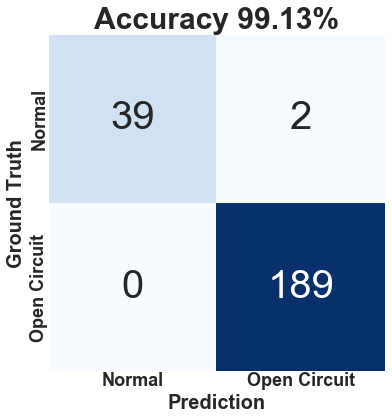

In [316]:
confusion_plot(cm,score)

In [236]:
pred = rf_model.predict(X_test)

for i in range(len(pred)):
    if pred[i] != y_test[i]:
        day = test_date[i]
        print(day)

12/6/18
5/1/19
4/15/18
12/23/18
7/17/19
7/17/19
4/3/18
1/2/19
12/22/19
1/6/20
1/6/20
12/27/18
1/10/19
